# MLB Player Digital Engagement Forecasting Part 3


This is *MLB Digital Engagement Forecasting* competition held by Kaggle. This notebook will:
- load and join the data,
- create a feature set,
- predict with trained model.
- analysis.
- make a submission.




In [1]:
import gc
import sys
import warnings
from joblib import Parallel, delayed
from pathlib import Path
import datetime
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.experimental.preprocessing import StringLookup

warnings.simplefilter("ignore")

# 1. Create Training Data #

### Read and extract dataframes

In [2]:
# Helper function to unpack json found in daily data
def unpack_json(json_str):
    return pd.DataFrame() if pd.isna(json_str) else pd.read_json(json_str)


def unpack_data(data, dfs=None, n_jobs=-1):
    if dfs is not None:
        data = data.loc[:, dfs]
    unnested_dfs = {}
    for name, column in data.iteritems():
        daily_dfs = Parallel(n_jobs=n_jobs)(
            delayed(unpack_json)(item) for date, item in column.iteritems())
        df = pd.concat(daily_dfs)
        unnested_dfs[name] = df
    return unnested_dfs

We use features from following tables: seasons,teams,players,and awards

In [3]:
data_dir = Path('../input/mlb-player-digital-engagement-forecasting/')

df_names = ['seasons', 'teams', 'players', 'awards']

for name in df_names:
    globals()[name] = pd.read_csv(data_dir / f"{name}.csv")

kaggle_data_tabs = widgets.Tab()
# Add Output widgets for each pandas DF as tabs' children
kaggle_data_tabs.children = list([widgets.Output() for df_name in df_names])

for index in range(0, len(df_names)):
    # Rename tab bar titles to df names
    kaggle_data_tabs.set_title(index, df_names[index])
    
    # Display corresponding table output for this tab name
    with kaggle_data_tabs.children[index]:
        display(eval(df_names[index]))

display(kaggle_data_tabs)
del teams

### Players tables(Library containing high level information about all MLB players in this dataset):
Creating dummies for players birthcountry. Features used in the model:birthyear, birthcountry, and primary position code

In [4]:
players_1=players[players['playerForTestSetAndFuturePreds']==True].copy()
players_1.loc[players_1['playerForTestSetAndFuturePreds']==True,"birthCountry"].unique()
players_1.loc[(players_1['birthCountry']=='Taiwan')|(players_1['birthCountry']=='South Korea')|(players_1['birthCountry']=='Japan')|(players_1['birthCountry']=="China"),"birthCountry"]="Asia"
players_1.loc[(players_1['birthCountry']=='Germany')|(players_1['birthCountry']=='Netherlands'),'birthCountry']='Europe'
players_1.loc[(players_1['birthCountry']!='USA')&(players_1['birthCountry']!='Europe')&(players_1['birthCountry']!='Asia'),'birthCountry']='America'
players_1=players_1[['playerId','birthCountry','DOB','heightInches','weight','primaryPositionCode']]
#players_1=pd.get_dummies(players_1,columns=['birthCountry','primaryPositionCode'])
players_1['DOB'] = pd.PeriodIndex(players_1.DOB, freq='D')
players_1['birthyear']=players_1.DOB.dt.year
players_1.drop('DOB',axis=1,inplace=True)

The training data is a time-indexed collection of nested JSON fields containing information about each player. Our target is the `nextDayPlayerEngagement` column, while the remaining columns could be used to construct features.

In [5]:
%%time
# Define dataframes to load from training set
dfs = [
    'nextDayPlayerEngagement',  # targets
    'playerBoxScores',  # features
    # Other dataframes available for features:
    'games',
    'rosters',
    #'teamBoxScores',
    'transactions',
    'standings',
    'awards',
    # 'events',
    'playerTwitterFollowers',
]

# Read training data
training = pd.read_csv(
    data_dir / 'train.csv',
    usecols=['date'] + dfs,
)

# Convert training data date field to datetime type
training['date'] = pd.to_datetime(training['date'], format="%Y%m%d")
training = training.set_index('date').to_period('D')
print(training.info())

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1216 entries, 2018-01-01 to 2021-04-30
Freq: D
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   nextDayPlayerEngagement  1216 non-null   object
 1   games                    639 non-null    object
 2   rosters                  1216 non-null   object
 3   playerBoxScores          538 non-null    object
 4   transactions             1103 non-null   object
 5   standings                531 non-null    object
 6   awards                   294 non-null    object
 7   playerTwitterFollowers   40 non-null     object
dtypes: object(8)
memory usage: 85.5+ KB
None
CPU times: user 31.6 s, sys: 6.57 s, total: 38.1 s
Wall time: 1min 5s


### Quick overview of the training table

In [6]:
training.head()

,nextDayPlayerEngagement,games,rosters,playerBoxScores,transactions,standings,awards,playerTwitterFollowers
date,,,,,,,,
2018-01-01,"[{""engagementMetricsDate"":""2018-01-02"",""player...",NaN,"[{""playerId"":400121,""gameDate"":""2018-01-01"",""t...",NaN,"[{""transactionId"":340732,""playerId"":547348,""pl...",NaN,NaN,"[{""date"":""2018-01-01"",""playerId"":545361,""playe..."
2018-01-02,"[{""engagementMetricsDate"":""2018-01-03"",""player...",NaN,"[{""playerId"":134181,""gameDate"":""2018-01-02"",""t...",NaN,"[{""transactionId"":339458,""playerId"":621173,""pl...",NaN,NaN,NaN
2018-01-03,"[{""engagementMetricsDate"":""2018-01-04"",""player...",NaN,"[{""playerId"":425492,""gameDate"":""2018-01-03"",""t...",NaN,"[{""transactionId"":347527,""playerId"":572389,""pl...",NaN,NaN,NaN
2018-01-04,"[{""engagementMetricsDate"":""2018-01-05"",""player...",NaN,"[{""playerId"":282332,""gameDate"":""2018-01-04"",""t...",NaN,"[{""transactionId"":339549,""playerId"":545343,""pl...",NaN,NaN,NaN
2018-01-05,"[{""engagementMetricsDate"":""2018-01-06"",""player...",NaN,"[{""playerId"":282332,""gameDate"":""2018-01-05"",""t...",NaN,"[{""transactionId"":341195,""playerId"":628336,""pl...",NaN,NaN,NaN


### Unpack Json file with created equation

In [7]:
%time
# Unpack nested dataframes and store in dictionary `training_dfs`
training_dfs = unpack_data(training, dfs=dfs)
print('\n', training_dfs.keys())

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.58 µs

 dict_keys(['nextDayPlayerEngagement', 'playerBoxScores', 'games', 'rosters', 'transactions', 'standings', 'awards', 'playerTwitterFollowers'])


### Games Table:
Transfer game/row data structure to team/row structure.Features newly created for the model:wins difference,score difference 


In [8]:
def make_games(dfs:dict): 
    home=dfs['games'].copy()
    if "gameDate" in  home.columns:
        home=home.rename(columns={'homeId':'teamId','homeWins':'teamWins','awayWins':'oppWins','homeScore':'teamScore','awayScore':'oppScore','homeWinner':'teamWinner',"gameDate":"date"})
        home=home[['teamId','teamWins','oppWins','teamScore','oppScore','teamWinner',"date","gameType"]]
        away=dfs['games'].copy()
        away=away.rename(columns={'awayId':'teamId','homeWins':'oppWins','awayWins':'teamWins','homeScore':'oppScore','awayScore':'teamScore','awayWinner':'teamWinner',"gameDate":"date"})
        away=away[['teamId','teamWins','oppWins','teamScore','oppScore','teamWinner',"date","gameType"]]
        away
        games=pd.concat([home,away],axis=0)
        games["winsdiff"]=games['teamWins']-games['oppWins']
        games["scorediff"]=games['teamScore']-games['oppScore']
        games=games.drop(['teamWins','oppWins','teamScore','oppScore'],axis=1)
        games = games.groupby(['date', 'teamId'], as_index=False).mean()
        games['date']=pd.PeriodIndex(games.date,freq='D')
    else:
        games=dfs['games'].copy()
        games[['teamId']]=np.nan
        games[['date']]=np.nan
    return games

### Include players' average target value of the previous year as features

In [9]:
targ = training_dfs['nextDayPlayerEngagement'].copy()
targets = ["target1", "target2", "target3", "target4"]
targ  = targ .astype({name: np.float32 for name  in targets})
targ = targ.rename(columns={'engagementMetricsDate': 'date'})
targ['date'] = pd.to_datetime(targ['date'])
targ = targ.set_index('date').to_period('D')
targ.index = targ.index - 1
targ=targ.reset_index()

In [10]:
targ['seasonId']=targ.date.dt.year+1
targ.drop(['date'],axis=1,inplace=True)
targ=targ.groupby(by=['seasonId','playerId'],as_index=False).mean()
targ=targ.loc[(targ.seasonId!=2022),:]
# Match target dates to feature dates and create date index
targ=targ.rename(columns={"target1":"meantarget1","target2":"meantarget2","target3":"meantarget3","target4":"meantarget4"})
targ = targ.astype({'playerId': str})

### Rosters: player_id, team_id, status_code,game_date

In [11]:
def make_rosters(dfs:dict):
    rosters=dfs['rosters'].copy()
    if "playerId" in rosters.columns:
        rosters=rosters[['playerId','gameDate','teamId','statusCode']]
        #rosters=pd.get_dummies(rosters,columns=['statusCode'])
        rosters=rosters.rename(columns={'gameDate':'date'})
        rosters['date']=pd.PeriodIndex(rosters.date,freq='D')
    else:
        rosters[['playerId']]=np.nan
        rosters[['date']]=np.nan
        rosters[['teamId']]=np.nan
    return rosters

### twitter followers: player_id, date, numberof followers

In [12]:

def make_playerTwitterFollowers(dfs:dict):
    twitfollowers=dfs['playerTwitterFollowers'].copy()
    if 'playerId' in  twitfollowers.columns:
        twitfollowers=twitfollowers[['date','playerId','numberOfFollowers']]
        twitfollowers['date']=pd.PeriodIndex(twitfollowers.date,freq='D')
    else:
        twitfollowers[['playerId']]=np.nan
        twitfollowers[['date']]=np.nan
    return twitfollowers


### Team_Standing:'teamid','gamedate','divisionRank','leagueRank','wildCardRank','pct','wins','eliminated','wildCardEliminated'

In [13]:
standings_feature=['divisionRank','leagueRank','wildCardRank','pct','wins','eliminationNumber','wildCardEliminationNumber'
       ]
def make_standings(dfs:dict,standings_feature):
    standings=dfs['standings'].copy()
    if 'teamId' in standings.columns: 
        standings=standings[['teamId','gameDate']+standings_feature]
        standings=standings.rename(columns={'gameDate':'date'})
        standings['date']=pd.PeriodIndex(standings.date,freq='D')
        standings['eliminated']=standings['eliminationNumber']=='E'
        standings['wildeliminated']=standings['wildCardEliminationNumber']=='E'
        standings=standings.drop(['eliminationNumber','wildCardEliminationNumber'],axis=1)
    else:
        standings[['teamId']]=np.nan
        standings[['date']]=np.nan
    return standings

# Previous year award

In [14]:
awardhist=training_dfs['awards'].copy()

In [15]:
awards=['All-MLB First Team', 'All-MLB Second Team','NL Comeback Player of the Year',
       'Edgar Martinez Outstanding DH of the Year',
       'AL Comeback Player of the Year', 'The Hutch Award','AL Cy Young', 'NL Cy Young', 'AL MVP',
       'NL MVP','MLB Players Choice NL Comeback Player',
       'MLB Players Choice NL Outstanding Pitcher',
       'MLB Players Choice NL Outstanding Rookie',
       'MLB Players Choice NL Outstanding Player',
       'Rawlings NL Platinum Glove', 'Babe Ruth Award',
       'MLB Players Choice Player of the Year',
       'MLB Players Choice Man of the Year',
       'MLB Players Choice AL Outstanding Player',
       'MLB Players Choice AL Comeback Player',
       'MLB Players Choice AL Outstanding Pitcher',
       'MLB Players Choice AL Outstanding Rookie', 'Wilson Defensive Player of the Year',
       'Wilson MLB Defensive Player of the Year', 'AL Silver Slugger',
       'NL Silver Slugger', 'MLBPAA Heart and Hustle Award',
       'Rawlings AL Platinum Glove', 'Roberto Clemente Award', 'NL Hank Aaron Award',
       'AL Hank Aaron Award', 'Trevor Hoffman NL Reliever of the Year',
       'Mariano Rivera AL Reliever of the Year',
       'World Series Championship', 'World Series MVP','Baseball America Minor League Player of the Year',
       'Baseball America Major League Rookie of the Year',
       'Baseball America Major League Player of the Year','Home Run Derby Winner', 'All-Star MVP', 'AL All-Star',
       'NL All-Star',]


In [16]:
awardhist=training_dfs['awards'].copy()
awardhist=awardhist[['awardSeason','playerId','awardName']]
awardhist=awardhist.loc[awardhist.awardName.isin(awards),:]
awardhist=awardhist.rename(columns={'awardSeason':'seasonId'})
awardhist['seasonId']=awardhist['seasonId']+1
awardhist=pd.get_dummies(awardhist,'awardName')
awardhist=awardhist.groupby(['playerId','seasonId'],as_index=False).sum()
awardhist['playerId']=[str(a) for a in awardhist.playerId]

In [17]:
#features = [
#    "hits",
#    'doubles', 
#    'triples',
#    "strikeOuts",
#    "homeRuns",
#    "runsScored",
#    "stolenBases",
#    "strikes",
#    "flyOuts",
#    "groundOuts",
#    "errors",
#    "rbi",
#    "baseOnBalls",
#    "gamesPlayedPitching", 
#    'gamesStartedPitching',
#    'completeGamesPitching', 
#    'shutoutsPitching', 
#    'winsPitching',
#    'lossesPitching',
#    'runsPitching', 
#    'homeRunsPitching', 
#    'strikeOutsPitching',
#    'baseOnBallsPitching',
#    'inningsPitched',
#    'teamName',
#    'positionName',
#]


### game_date features (Box Score Statistics)

In [18]:
features = ['home',
    'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced',  'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances','battingOrder',
    'positionName'
]

In [19]:
gc.collect
del training

In [20]:
pids_test = players.playerId.loc[
    players.playerForTestSetAndFuturePreds.fillna(False)
].astype(str)
pids_test.shape

(1187,)

In [21]:
# Players in the test set. We'll filter our data for only this set of players
pids_test = players.playerId.loc[
    players.playerForTestSetAndFuturePreds.fillna(False)
].astype(str)

# Name of target columns
targets = ["target1", "target2", "target3", "target4"]

def make_playerBoxScores(dfs: dict, features):
    X = dfs['playerBoxScores'].copy()
    if 'playerId' in X.columns:
        X = dfs['playerBoxScores'].copy()
        X = X[['gameDate', 'playerId'] + features]
        X = X.rename(columns={'gameDate': 'date'})
        X['date'] = pd.PeriodIndex(X.date, freq='D')
        X=X[features+['date','playerId']]
        X['battingOrder']=X['battingOrder'].fillna(0)
        X.loc[X['battingOrder']==0,'battingOrder']=10009
        X['starting']=X['battingOrder']%100
        X['starting']=X['starting']==0
        X['order']=X['battingOrder']//100
        X=pd.get_dummies(X,columns=['order'])
        X.drop(['battingOrder'],axis=1,inplace=True)
        # Set dtypes
        X = X.astype({'playerId': str,'starting': int})
        X['positionName']=X['positionName'].fillna(value="X")
        # Create date index
        # Aggregate multiple games per day by summing
        X = X.groupby(['date', 'playerId'], as_index=False).mean()
    else:
        X[['playerId']]=np.nan
        X[['date']]=np.nan
    return X

# Set dtypes
#def make_playerTwitterFollowers(dfs:dict):
#    X=dfs['playerTwitterFollowers'].copy()
#    X=X[['date', 'playerId','numberOfFollowers']]
#    X['date'] = pd.PeriodIndex(X.date, freq='D')
##    # Aggregate multiple games per day by summing
#    X = X.groupby(['date', 'playerId'], as_index=False).sum()
#    return X

def make_targets(training_dfs: dict):
    Y = training_dfs['nextDayPlayerEngagement'].copy()
    # Set dtypes
    Y = Y.astype({name: np.float32 for name  in targets})
    Y = Y.astype({'playerId': str})
    # Match target dates to feature dates and create date index
    Y = Y.rename(columns={'engagementMetricsDate': 'date'})
    Y['date'] = pd.to_datetime(Y['date'])
    Y = Y.set_index('date').to_period('D')
    Y.index = Y.index - 1
    return Y.reset_index()


#def join_datasets(dfs):
#    dfs = [x.pivot(index='date', columns='playerId') for x in dfs]
#    df = pd.concat(dfs, axis=1).stack().reset_index('playerId')
#    return df

#def make_trainX(test_dfs: dict, features):
#    X = make_playerBoxScores(test_dfs, features)
#    X = X.merge(pids_test, how='right')
    #fourier_terms = CalendarFourier(freq='A', order=4)
    #deterministic = DeterministicProcess(
    #    index=X.index,
    #    order=0,
    #    seasonal=False,  # set to True for weekly seasonality
    #    additional_terms=[fourier_terms],
    #)
    #X = pd.concat([X, deterministic.in_sample()], axis=1)
 #   return X
#def make_trainy(training_dfs: dict,
#                      targets):

#    Y = make_targets(training_dfs)
    # Filter for players in test set
#    Y=Y.loc[Y.playerId.isin(pids_test), :]
    # Convert from long to wide format
    # Restore features and target
    # Fill missing values in features
#    return Y
    # Create train / validation splits
#X,Y=make_trainX(training_dfs,features),make_trainy(training_dfs,targets)

### Merging All Using Tables (test set start from 2021 June)
Before merging the tables, we create new features of "season part" since the atmosphere at the beginning of the season and that at the end of the season should be very different. We use 2021 season as test set, and 2019,2020 as training set.

In [22]:
def make_training_data(training_dfs: dict,
                       features,
                       targets,
                       fourier=4,
                       test_size=30):
    # Process dataframes
    X = make_playerBoxScores(training_dfs, features)
    standings=make_standings(training_dfs,standings_feature)
    games=make_games(training_dfs)
    rosters=make_rosters(training_dfs)
    #transactions=make_transactions(training_dfs)
    TwitterFollowers=make_playerTwitterFollowers(training_dfs)
    Y = make_targets(training_dfs)
    rosters['playerId']=[str(x) for x in rosters.playerId]
    players_1['playerId']=[str(x) for x in players_1.playerId]
    #transactions['playerId']=[str(x) for x in transactions.playerId]
    TwitterFollowers['playerId']=[str(x) for x in TwitterFollowers.playerId]
    # Merge for processing
    Y =Y.loc[Y.playerId.isin(pids_test), :]
    df = Y.merge(X,how='left',on=['date','playerId'])
    # Filter for players in test set
    df['seasonId']=df.date.dt.year
    df=df.loc[(df.seasonId!=2018),:]
    df=df.merge(awardhist,how='left',on=['seasonId','playerId'])
    df=df.merge(targ,how='left',on=['seasonId','playerId'])
    unique=pd.DataFrame({'date':df.date.unique()})
    unique['seasonId']=unique.date.dt.year
    unique=unique.merge(seasons,on='seasonId')
    unique['seasonPart'] = np.select(
        [
        unique['date'] < unique['preSeasonStartDate'], 
        unique['date'] <unique['regularSeasonStartDate'],
        unique['date'] <= unique['lastDate1stHalf'],
        unique['date'] < unique['firstDate2ndHalf'],
        unique['date'] <= unique['regularSeasonEndDate'],
        unique['date'] < unique['postSeasonStartDate'],
       unique['date'] <= unique['postSeasonEndDate'],
        unique['date'] >unique['postSeasonEndDate']
        ], 
        [
        'Offseason',
        'Preseason',
        'Reg Season 1st Half',
        'All-Star Break',
        'Reg Season 2nd Half',
        'Between Reg and Postseason',
        'Postseason',
        'Offseason'
        ], 
        default = np.nan
        )
    unique=unique[['date','seasonPart']]
    df=df.merge(unique,how='left',on='date')
    df=df.loc[df.seasonPart!='Offseason',:]
    #df=df.loc[df.seasonPart!='Preseason',:]
    #df=df.loc[df.seasonPart!='Postseason',:]
    #df=df.loc[df.seasonPart!='Offseason',:]
    df=df.drop('seasonId',axis=1)
    df=df.merge(rosters,how='left',on=['date','playerId'])
    #df=df.merge(transactions,how='left',on=['date','playerId'])
    df=df.merge(TwitterFollowers,how='left',on=['date','playerId'])
    df=df.merge(standings,how='left',on=['date','teamId'])
    df=df.merge(games,how='left',on=['date','teamId'])
    df=df.merge(players_1,how='left',on=['playerId'])
    #df['seasonId']=df.date.dt.year
    #df['age']=df['seasonId']-df['birthyear']
    #df.drop('seasonId',axis=1, inplace=True)
    #df=pd.get_dummies(df,columns=['teamId'])
    # Convert from long to wide format
    #df = df.pivot(columns="playerId")
    # Restore features and targets
    df['seasonId']=df.date.dt.year
    df['age']=df['seasonId']-df['birthyear']
    train_df=df.loc[(df.seasonId!=2021),:]
    test_df=df.loc[(df.seasonId==2021),:]
    train_df=pd.get_dummies(train_df,columns=['seasonPart'])
    test_df=pd.get_dummies(test_df,columns=['seasonPart'])
    missing_cols = set( train_df.columns ) - set(test_df.columns )
    for c in missing_cols:
        test_df[c] = 0
    #y_train = train_df[targets]
    #y_valid = test_df[targets]
    # Fill missing values in features
    #X_train =train_df.drop(targets+['date','playerId','birthyear','seasonId'],axis=1)
    #X_train.fillna(0, inplace=True)
    #X_valid =test_df.drop(targets+['date','playerId','birthyear','seasonId'],axis=1)
    #X_valid.fillna(0, inplace=True)
    # Create temporal features
    # Create train / validation splits,:]
    #X_train,X_valid=X.loc[train_id,:],X.loc[test_id,:]
    #y_train,y_valid=Y.loc[train_id,:],Y.loc[test_id,:]
    return train_df

In [23]:
train_df=make_training_data(training_dfs,
                       features,
                       targets
                       )

In [24]:
rosters=training_dfs['rosters'].copy()
rosters.loc[rosters['statusCode']=='D10','status']

7       Injured 10-Day
29      Injured 10-Day
80      Injured 10-Day
81      Injured 10-Day
88      Injured 10-Day
             ...      
1188    Injured 10-Day
1203    Injured 10-Day
1208    Injured 10-Day
1236    Injured 10-Day
1255    Injured 10-Day
Name: status, Length: 47279, dtype: object

In [25]:
gc.collect()

18068

# Player Status

In [26]:
piestatus=train_df.groupby('statusCode').size().reset_index()
piestatus.columns=['statusCode','count']


Around 76% of observations are active in Major League, then 'Resigned to Minor', then 'Injured-60-days', and last 'injured 10 days'

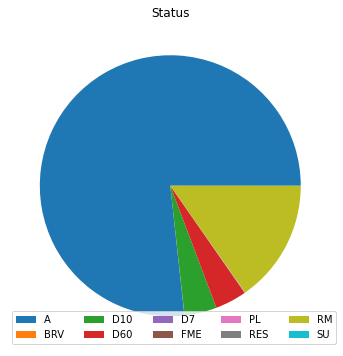

In [27]:
plt.figure(figsize=(16, 6))
plt.pie(piestatus['count'], labels=piestatus['statusCode'],labeldistance=None)
plt.title('Status')
plt.legend(loc="lower left", ncol=5)
plt.show()


# Player Country

Most of the players are born in the USA, then other America country,then Asia, and last Europe

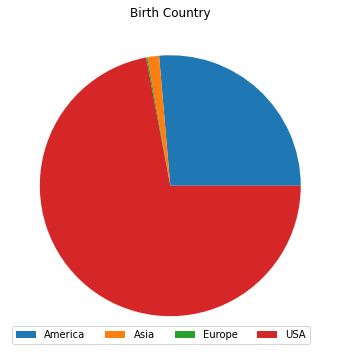

In [28]:
birthcountry=train_df.groupby('birthCountry').size().reset_index()
birthcountry.columns=['birthCountry','count']
plt.figure(figsize=(16, 6))
plt.pie(birthcountry['count'], labels=birthcountry['birthCountry'],labeldistance=None)
plt.title('Birth Country')
plt.legend(loc="lower left", ncol=5)
plt.show()

# Player Primary Position

There are a lot of pitchers in the dataset

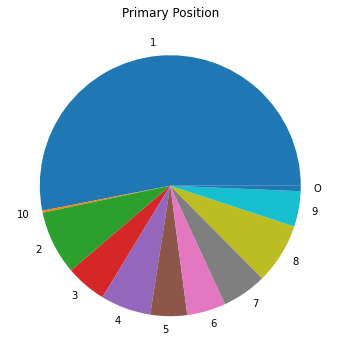

In [29]:
position=train_df.groupby('primaryPositionCode').size().reset_index()
position.columns=['primaryPositionCode','count']
plt.figure(figsize=(16, 6))
plt.pie(position['count'], labels=position['primaryPositionCode'])
plt.title('Primary Position')
plt.show()

## Distribution of the Four Targets

All four targets are rightly scewed

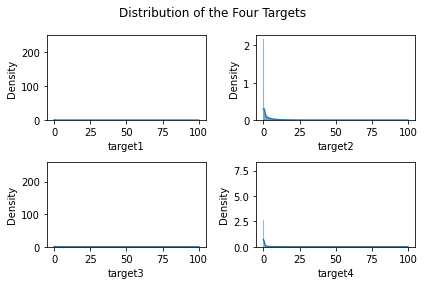

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,2)
fig.suptitle('Distribution of the Four Targets')
sns.histplot(ax=axes[0,0],data=train_df,x='target1',stat='density',kde=True)
sns.histplot(ax=axes[0,1],data=train_df,x='target2',stat='density',kde=True)
sns.histplot(ax=axes[1,0],data=train_df,x='target3',stat='density',kde=True)
sns.histplot(ax=axes[1,1],data=train_df,x='target4',stat='density',kde=True)
fig.tight_layout()
plt.show()

## Strong Correlation Between Current Targets and Average Target in Previous Year ##

Target1

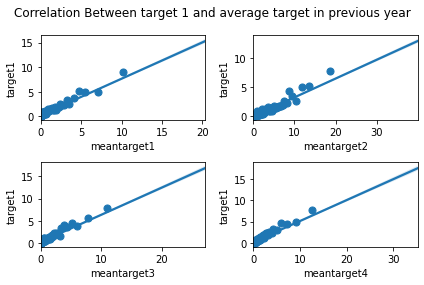

In [31]:
fig, axes = plt.subplots(2,2)
fig.suptitle('Correlation Between target 1 and average target in previous year')
sns.regplot(x='meantarget1',y='target1',data=train_df,x_bins=100,ci=95,ax=axes[0,0])
sns.regplot(x='meantarget2',y='target1',data=train_df,x_bins=100,ci=95,ax=axes[0,1])
sns.regplot(x='meantarget3',y='target1',data=train_df,x_bins=100,ci=95,ax=axes[1,0])
sns.regplot(x='meantarget4',y='target1',data=train_df,x_bins=100,ci=95,ax=axes[1,1])
fig.tight_layout()
plt.show()

Target2

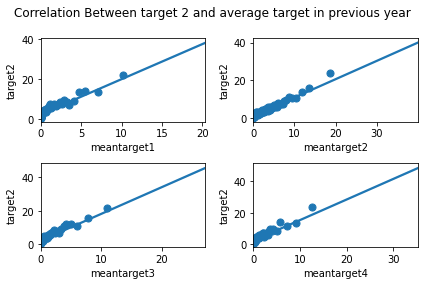

In [32]:
fig, axes = plt.subplots(2,2)
fig.suptitle('Correlation Between target 2 and average target in previous year')
sns.regplot(x='meantarget1',y='target2',data=train_df,x_bins=100,ci=95,ax=axes[0,0])
sns.regplot(x='meantarget2',y='target2',data=train_df,x_bins=100,ci=95,ax=axes[0,1])
sns.regplot(x='meantarget3',y='target2',data=train_df,x_bins=100,ci=95,ax=axes[1,0])
sns.regplot(x='meantarget4',y='target2',data=train_df,x_bins=100,ci=95,ax=axes[1,1])
fig.tight_layout()
plt.show()

Target 3 

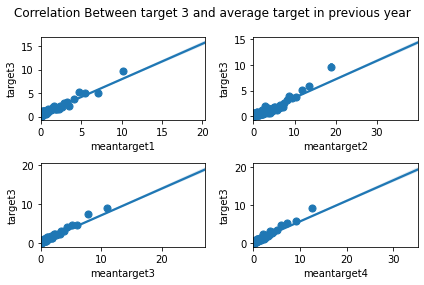

In [33]:
fig, axes = plt.subplots(2,2)
fig.suptitle('Correlation Between target 3 and average target in previous year')
sns.regplot(x='meantarget1',y='target3',data=train_df,x_bins=100,ci=95,ax=axes[0,0])
sns.regplot(x='meantarget2',y='target3',data=train_df,x_bins=100,ci=95,ax=axes[0,1])
sns.regplot(x='meantarget3',y='target3',data=train_df,x_bins=100,ci=95,ax=axes[1,0])
sns.regplot(x='meantarget4',y='target3',data=train_df,x_bins=100,ci=95,ax=axes[1,1])
fig.tight_layout()
plt.show()

Target 4

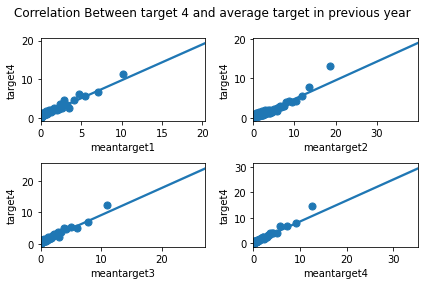

In [34]:
fig, axes = plt.subplots(2,2)
fig.suptitle('Correlation Between target 4 and average target in previous year')
sns.regplot(x='meantarget1',y='target4',data=train_df,x_bins=100,ci=95,ax=axes[0,0])
sns.regplot(x='meantarget2',y='target4',data=train_df,x_bins=100,ci=95,ax=axes[0,1])
sns.regplot(x='meantarget3',y='target4',data=train_df,x_bins=100,ci=95,ax=axes[1,0])
sns.regplot(x='meantarget4',y='target4',data=train_df,x_bins=100,ci=95,ax=axes[1,1])
fig.tight_layout()
plt.show()

## Correlation between Month and Targets

In [35]:
train_df['month']=train_df['date'].dt.month


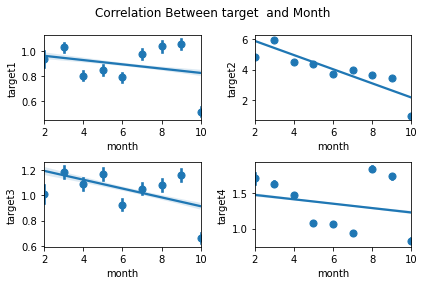

In [36]:
fig, axes = plt.subplots(2,2)
fig.suptitle('Correlation Between target  and Month')
sns.regplot(x='month',y='target1',data=train_df,x_bins=100,ci=95,ax=axes[0,0])
sns.regplot(x='month',y='target2',data=train_df,x_bins=100,ci=95,ax=axes[0,1])
sns.regplot(x='month',y='target3',data=train_df,x_bins=100,ci=95,ax=axes[1,0])
sns.regplot(x='month',y='target4',data=train_df,x_bins=100,ci=95,ax=axes[1,1])
fig.tight_layout()
plt.show()

In [37]:
#history_df = pd.DataFrame(history.history)
#history_df.loc[:, ['loss', 'val_loss']].plot()

# Correlation between 4 Targets 

Text(0.5, 1.0, 'Correlation Heatmap')

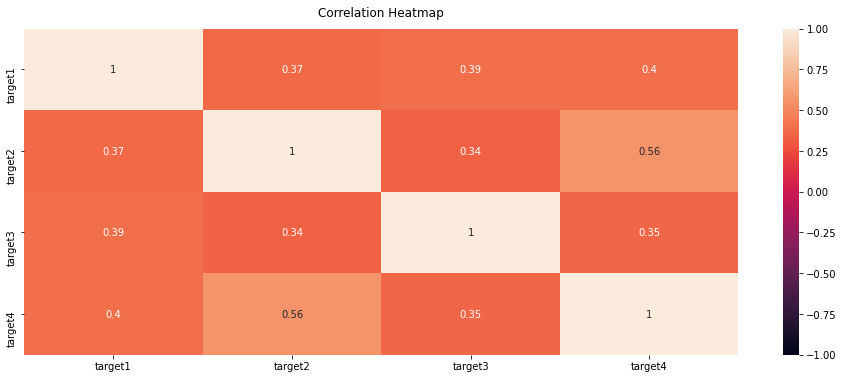

In [38]:
plt.figure(figsize=(16, 6))
sns.heatmap(train_df[['target1','target2','target3','target4']].corr(),vmin=-1,vmax=1, annot=True)
plt.title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)